<a href="https://colab.research.google.com/github/shyamjith94/TimeSeriesDataAnalysis/blob/main/KerasRNNTimeSeriesMultiVariable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.callbacks import EarlyStopping

In [65]:
data = pd.read_csv("/content/drive/MyDrive/TimeSeriesDataAnalysis/Data/energydata_complete.csv", index_col='date', infer_datetime_format=True)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

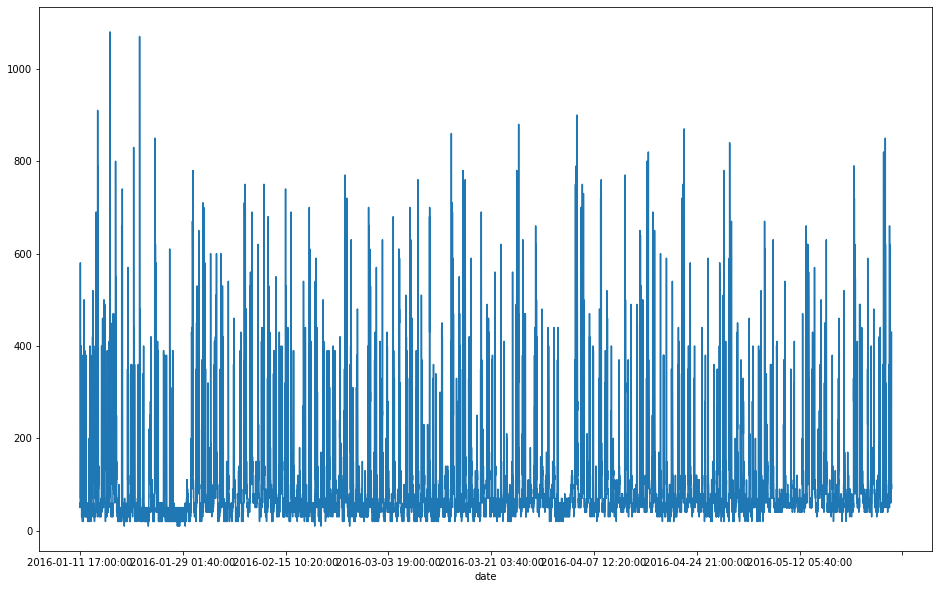

In [67]:
data['Appliances'].plot(figsize=(16,10))

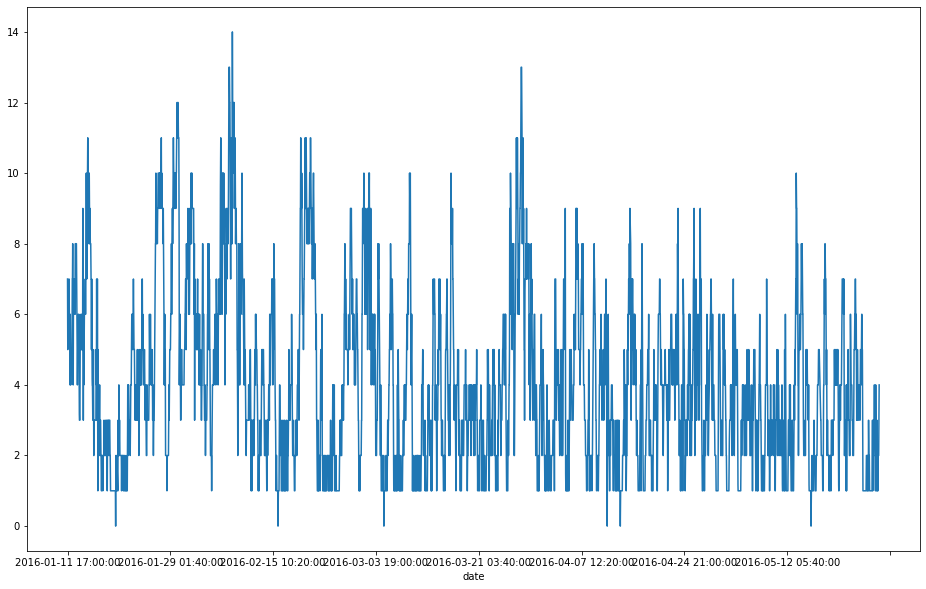

In [68]:
data['Windspeed'].plot(figsize=(16,10))

In [69]:
data.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [70]:
data.loc['2016-05-01':]

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.200000,38.200000,18.390000,41.400000,23.200000,36.400000,19.73,37.730000,19.50,47.290000,4.800000,40.060000,19.500000,31.600000,22.2000,40.000000,19.166667,38.200000,4.300000,763.700000,86.000000,2.000000,40.000000,2.200000,15.310003,15.310003
2016-05-01 00:10:00,60,0,21.150000,38.172500,18.390000,41.500000,23.133333,36.466667,19.70,37.663333,19.50,47.290000,4.800000,40.090000,19.500000,31.600000,22.2000,40.400000,19.133333,38.290000,4.283333,763.716667,86.333333,2.166667,38.166667,2.216667,11.240067,11.240067
2016-05-01 00:20:00,50,0,21.133333,38.090000,18.323333,41.500000,23.200000,36.500000,19.70,37.590000,19.50,47.260000,4.660000,40.030000,19.500000,31.600000,22.2000,41.000000,19.133333,38.363333,4.266667,763.733333,86.666667,2.333333,36.333333,2.233333,21.808814,21.808814
2016-05-01 00:30:00,50,0,21.100000,38.090000,18.290000,41.500000,23.200000,36.500000,19.70,37.500000,19.50,47.260000,4.530000,41.300000,19.500000,31.600000,22.2000,41.333333,19.166667,38.500000,4.250000,763.750000,87.000000,2.500000,34.500000,2.250000,47.000534,47.000534
2016-05-01 00:40:00,60,0,21.100000,38.030000,18.290000,41.560000,23.200000,36.500000,19.70,37.500000,19.50,47.200000,4.590000,41.833333,19.500000,31.600000,22.2000,41.626667,19.166667,38.633333,4.233333,763.766667,87.333333,2.666667,32.666667,2.266667,8.059441,8.059441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.70,45.590000,23.20,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.70,45.590000,23.23,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.70,45.730000,23.23,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117


**predicting 24 to future**

In [71]:
# Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network
data = data.round(2)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.60,19.2,44.79,19.79,44.73,19.00,45.57,17.17,55.20,7.03,84.26,17.20,41.63,18.2,48.90,17.03,45.53,6.60,733.5,92.0,7.00,63.00,5.3,13.28,13.28
2016-01-11 17:10:00,60,30,19.89,46.69,19.2,44.72,19.79,44.79,19.00,45.99,17.17,55.20,6.83,84.06,17.20,41.56,18.2,48.86,17.07,45.56,6.48,733.6,92.0,6.67,59.17,5.2,18.61,18.61
2016-01-11 17:20:00,50,30,19.89,46.30,19.2,44.63,19.79,44.93,18.93,45.89,17.17,55.09,6.56,83.16,17.20,41.43,18.2,48.73,17.00,45.50,6.37,733.7,92.0,6.33,55.33,5.1,28.64,28.64
2016-01-11 17:30:00,50,40,19.89,46.07,19.2,44.59,19.79,45.00,18.89,45.72,17.17,55.09,6.43,83.42,17.13,41.29,18.1,48.59,17.00,45.40,6.25,733.8,92.0,6.00,51.50,5.0,45.41,45.41
2016-01-11 17:40:00,60,40,19.89,46.33,19.2,44.53,19.79,45.00,18.89,45.53,17.20,55.09,6.37,84.89,17.20,41.23,18.1,48.59,17.00,45.40,6.13,733.9,92.0,5.67,47.67,4.9,10.08,10.08


In [72]:
len(data)

19735

In [73]:
data = data.loc['2016-05-01':]
len(data)

3853

In [74]:
# How many rows per day? We know its every 10 min
24*60/10

144.0

In [75]:
test_days = 2
test_ind = test_days *144

In [76]:
train_data = data[:-test_ind]
test_data = data[-test_ind:]

In [77]:
train_data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.40,23.20,36.40,19.73,37.73,19.5,47.29,4.80,40.06,19.5,31.6,22.2,40.00,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.50,23.13,36.47,19.70,37.66,19.5,47.29,4.80,40.09,19.5,31.6,22.2,40.40,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24
2016-05-01 00:20:00,50,0,21.13,38.09,18.32,41.50,23.20,36.50,19.70,37.59,19.5,47.26,4.66,40.03,19.5,31.6,22.2,41.00,19.13,38.36,4.27,763.73,86.67,2.33,36.33,2.23,21.81,21.81
2016-05-01 00:30:00,50,0,21.10,38.09,18.29,41.50,23.20,36.50,19.70,37.50,19.5,47.26,4.53,41.30,19.5,31.6,22.2,41.33,19.17,38.50,4.25,763.75,87.00,2.50,34.50,2.25,47.00,47.00
2016-05-01 00:40:00,60,0,21.10,38.03,18.29,41.56,23.20,36.50,19.70,37.50,19.5,47.20,4.59,41.83,19.5,31.6,22.2,41.63,19.17,38.63,4.23,763.77,87.33,2.67,32.67,2.27,8.06,8.06


**scaling data**

In [78]:
scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [79]:
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [80]:
length = 144
batch = 1
genetor_train = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch)
len(genetor_train)

3421

In [81]:
x, y = genetor_train[0]
print(f'geven\t {x.flatten()}')
print(f'predict\t {y}')

geven	 [0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]
predict	 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


In [82]:
scaled_train.shape

(3565, 28)

In [83]:
model = Sequential()
model.add(LSTM(100, input_shape=(length, scaled_train.shape[1]))) # activation default tanh
model.add(Dense(units=scaled_train.shape[1]))
model.compile(optimizer='adam', loss='mse')

In [84]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               51600     
_________________________________________________________________
dense_2 (Dense)              (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


**Early Stoping**

In [85]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch)

**Train Model**

In [86]:
model.fit_generator(genetor_train, epochs=10, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/10
3421/3421 [==============================] - 156s 46ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 2/10
3421/3421 [==============================] - 156s 46ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 3/10
3421/3421 [==============================] - 155s 45ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 4/10
3421/3421 [==============================] - 160s 47ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 5/10
3421/3421 [==============================] - 158s 46ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 6/10
3421/3421 [==============================] - 160s 47ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 7/10
3421/3421 [==============================] - 159s 47ms/step - loss: 0.0071 - val_loss: 0.0081


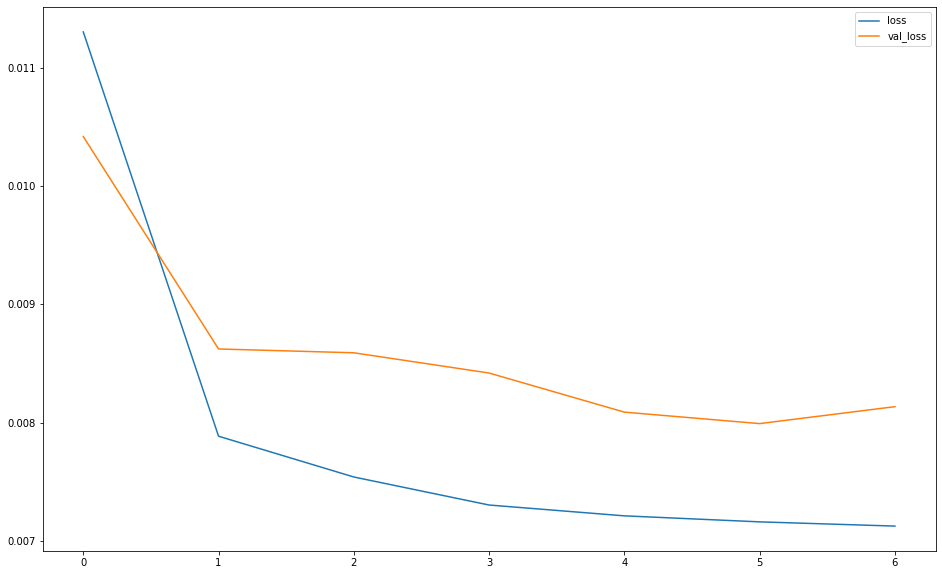

In [87]:
loss = pd.DataFrame(model.history.history)
loss.plot(figsize=(16,10))

In [88]:
first_eval_batch = scaled_train[-length:]
first_eval_batch

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [89]:
first_eval_batch = first_eval_batch.reshape(1, length, scaled_train.shape[1])

In [90]:
model.predict(first_eval_batch)

array([[ 0.1096049 ,  0.03301603,  0.7007586 ,  0.35374418,  0.57108885,
         0.40327922,  0.4141211 ,  0.41820103,  0.68963003,  0.40441436,
         0.27572492,  0.3468603 ,  0.65865654, -0.00448987,  0.59663314,
         0.3959937 ,  0.5278959 ,  0.32391658,  0.5325744 ,  0.375596  ,
         0.6355625 ,  0.5191741 ,  0.42718065,  0.21570879,  0.6051853 ,
         0.541456  ,  0.4774962 ,  0.4805344 ]], dtype=float32)

In [91]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test_data)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [92]:
test_predictions

[array([ 0.1096049 ,  0.03301603,  0.7007586 ,  0.35374418,  0.57108885,
         0.40327922,  0.4141211 ,  0.41820103,  0.68963003,  0.40441436,
         0.27572492,  0.3468603 ,  0.65865654, -0.00448987,  0.59663314,
         0.3959937 ,  0.5278959 ,  0.32391658,  0.5325744 ,  0.375596  ,
         0.6355625 ,  0.5191741 ,  0.42718065,  0.21570879,  0.6051853 ,
         0.541456  ,  0.4774962 ,  0.4805344 ], dtype=float32),
 array([1.0932395e-01, 4.4419587e-02, 6.9773984e-01, 3.3557135e-01,
        5.9341246e-01, 3.8412744e-01, 4.1017321e-01, 4.1248757e-01,
        6.7210585e-01, 3.9507526e-01, 2.5242046e-01, 3.2274196e-01,
        6.5481430e-01, 3.6928058e-04, 5.8700871e-01, 3.9681825e-01,
        5.3056699e-01, 3.2697916e-01, 5.2188969e-01, 3.9770699e-01,
        6.4299470e-01, 5.1579642e-01, 4.2689830e-01, 2.3387502e-01,
        6.2211221e-01, 5.4740584e-01, 4.7319019e-01, 4.7649792e-01],
       dtype=float32),
 array([0.11160444, 0.04767679, 0.6974789 , 0.32217896, 0.6166049 ,
   

In [93]:
true_predictions = scaler.inverse_transform(test_predictions)

In [94]:
true_predictions

array([[104.39577498,   0.990481  ,  24.50345284, ...,   7.75060613,
         23.87048545,  24.02230419],
       [104.17944044,   1.3325876 ,  24.48573286, ...,   7.85115868,
         23.65531371,  23.82060098],
       [105.93541667,   1.4303036 ,  24.48420109, ...,   7.90792007,
         23.55990224,  23.63593745],
       ...,
       [161.82566136,  -2.70911291,  24.16899136, ...,  22.32208064,
         25.94066792,  20.20344146],
       [161.82568431,  -2.70911381,  24.16898996, ...,  22.32208064,
         25.94066494,  20.20344295],
       [161.82569578,  -2.70911403,  24.16899066, ...,  22.32208467,
         25.94066494,  20.20343997]])

In [95]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test_data.columns)
true_predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,104.395775,0.990481,24.503453,36.801027,24.511478,34.022280,25.056825,36.682363,24.027410,37.633292,20.990813,50.329849,19.073727,0.740531,23.188533,34.645498,24.458749,38.997106,21.975902,37.996677,17.207724,755.937169,56.465729,2.157088,41.311116,7.750606,23.870485,24.022304
1,104.179440,1.332588,24.485733,36.298548,24.789853,33.378206,25.028637,36.574265,23.904741,37.427459,20.836072,48.903732,18.969986,1.021341,23.121451,34.664124,24.474428,39.069597,21.918204,38.476265,17.389071,755.860158,56.444271,2.338750,42.326733,7.851159,23.655314,23.820601
2,105.935417,1.430304,24.484201,35.928248,25.079063,32.689643,25.013419,36.470971,23.826357,37.249864,20.712860,47.518368,18.949878,1.320305,23.073754,34.711455,24.492897,39.100845,21.859105,38.858467,17.615098,755.862493,56.054514,2.520416,43.241001,7.907920,23.559902,23.635937
3,107.960548,1.460102,24.485850,35.595472,25.355922,31.987032,24.997763,36.362950,23.769024,37.065998,20.609524,46.305145,18.987060,1.629747,23.033340,34.745031,24.506571,39.087714,21.796845,39.159597,17.832653,755.899981,55.431668,2.702469,44.038115,7.909412,23.429038,23.459807
4,109.552722,1.473001,24.493867,35.277906,25.624100,31.310345,24.982636,36.255508,23.731344,36.885980,20.522121,45.284576,19.081479,1.940646,23.004594,34.761217,24.516874,39.041398,21.738218,39.399689,18.055578,755.979132,54.684343,2.891272,44.789122,7.877777,23.326121,23.313481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,161.825638,-2.709112,24.168989,37.111233,24.857286,33.406118,25.601147,38.030306,23.131000,39.237679,12.492250,4.541186,15.699047,135.228710,30.340262,35.143006,20.411893,36.072889,18.799294,54.020139,28.529567,774.242511,92.911724,19.818389,125.755181,22.322079,25.940662,20.203441
284,161.825604,-2.709112,24.168990,37.111232,24.857285,33.406122,25.601148,38.030307,23.131000,39.237679,12.492250,4.541190,15.699045,135.228697,30.340263,35.143007,20.411893,36.072892,18.799294,54.020137,28.529564,774.242514,92.911733,19.818389,125.755167,22.322085,25.940665,20.203441
285,161.825661,-2.709113,24.168991,37.111234,24.857285,33.406120,25.601147,38.030306,23.131000,39.237683,12.492250,4.541193,15.699045,135.228683,30.340264,35.143006,20.411893,36.072888,18.799294,54.020142,28.529567,774.242514,92.911715,19.818392,125.755181,22.322081,25.940668,20.203441
286,161.825684,-2.709114,24.168990,37.111233,24.857286,33.406122,25.601147,38.030306,23.131000,39.237679,12.492248,4.541193,15.699042,135.228683,30.340264,35.143007,20.411893,36.072887,18.799294,54.020139,28.529567,774.242514,92.911720,19.818392,125.755181,22.322081,25.940665,20.203443


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


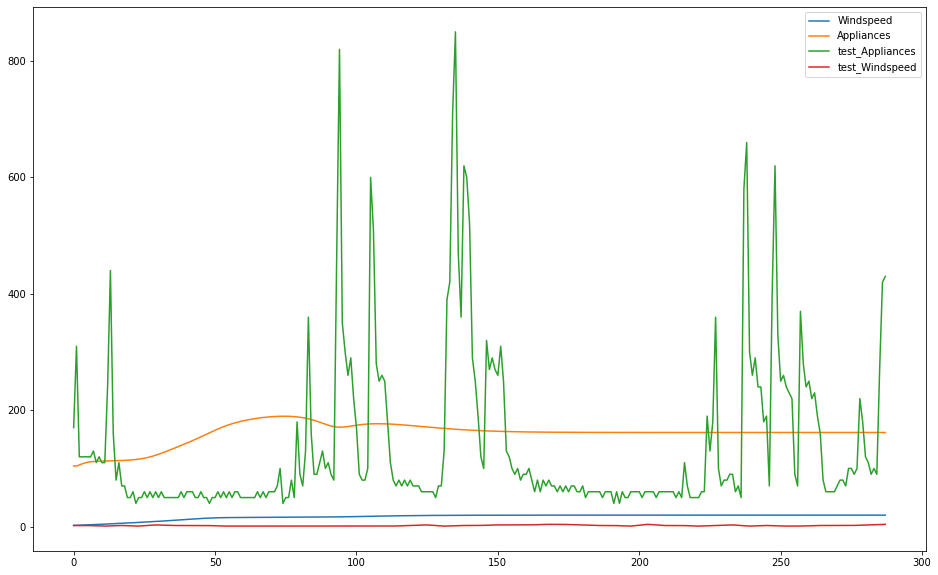

In [104]:
ploting = true_predictions[['Windspeed', 'Appliances']]
ploting['test_Appliances'] = test_data['Appliances'].values
ploting['test_Windspeed'] = test_data['Windspeed'].values
ploting.plot(figsize=(16,10))